In [33]:
import spacy
import spacy.cli
from spacy import displacy
from nltk.stem import WordNetLemmatizer
from graph.graph import Graph, visualize_graph
from graph.edge import Edge
from graph.vertex import Vertex

In [10]:
spacy.cli.download("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.0 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [11]:
nlp = spacy.load("en_core_web_sm")
lemmatizer = WordNetLemmatizer()

## Обработка глагольных рёбер

In [22]:
def get_syntactic_relations(doc):
    """
    Извлекает синтаксические связи (подлежащее - глагол - дополнение) из текста.
    Возвращает список троек (субъект, глагол, объект).
    """
    chunks = []  # (start_idx, end_idx, token, normalized_token, head, dep)
    relations = []  # (Concept1, Verb, Concept2)
    subjects = {}  # {verb: subject}

    # Добавляем существительные (NOUN, PROPN)
    for token in doc:
        if token.pos_ in {'NOUN', 'PROPN'}:
            lemma = lemmatizer.lemmatize(token.text.lower(), pos='n')  # Нормализация
            chunks.append((token.idx, token.idx + len(token.text), token, lemma, token.head, token.dep_))

    # Добавляем подлежащие
    for chunk in chunks:
        if chunk[5] == 'nsubj':
            subjects[chunk[4]] = chunk[3]  # Связываем сказуемое и подлежащее

    # Добавляем глагольные связи
    for chunk in chunks:
        if chunk[4].pos_ == 'VERB' and chunk[5] != 'nsubj':
            subject = subjects.get(chunk[4], None)
            if subject:
                relations.append((subject, chunk[4].text, chunk[3]))  # (подлежащее, глагол, дополнение)

    return relations

In [34]:
text = """The black cat sits on the mat. The dog sees the cat on the mat.
        A man reads a book. The book contains many interesting stories.
        John bought a new car. He drives it every day."""
    
doc = nlp(text)
pairs = get_syntactic_relations(doc)

graph1 = Graph()  # Используем твой графовый класс

# Добавляем вершины и рёбра
for pair in pairs:
    try:
        graph1.add_vertex(pair[0])
    except:
        pass
    try:
        graph1.add_vertex(pair[2])
    except:
        pass
    graph1.add_edge(pair[0], pair[2], pair[1], 0, 0)

# Выводим граф
print("Graph structure:")
print(graph1)
print("\nDetailed representation:")
print(repr(graph1))

print("\nEdges:")
for concept in graph1.vertices.keys():
    print(f"Concept: {concept}")
    print(graph1.get_vertex_edges(concept))

print("\nVertices:")
for concept in graph1.vertices.keys():
    print(graph1.vertices[concept])

Graph structure:
Graph(vertices=7, edges=4)

Detailed representation:
Graph(
	vertices=[Vertex(concept='dog', words=['dog']), Vertex(concept='cat', words=['cat']), Vertex(concept='man', words=['man']), Vertex(concept='book', words=['book']), Vertex(concept='story', words=['story']), Vertex(concept='john', words=['john']), Vertex(concept='car', words=['car'])],
	edges=[Edge(dog <--[sees]--> cat), Edge(man <--[reads]--> book), Edge(book <--[contains]--> story), Edge(john <--[bought]--> car)]
)

Edges:
Concept: dog
[Edge(dog <--[sees]--> cat)]
Concept: cat
[Edge(dog <--[sees]--> cat)]
Concept: man
[Edge(man <--[reads]--> book)]
Concept: book
[Edge(man <--[reads]--> book), Edge(book <--[contains]--> story)]
Concept: story
[Edge(book <--[contains]--> story)]
Concept: john
[Edge(john <--[bought]--> car)]
Concept: car
[Edge(john <--[bought]--> car)]

Vertices:
Vertex(concept='dog', words=['dog'])
Vertex(concept='cat', words=['cat'])
Vertex(concept='man', words=['man'])
Vertex(concept='book', 

## Обработка предложных рёбер

In [36]:
def find_nearest_vertex(token, chunk_to_vertex):
    """
    Ищет ближайшую вершину для токена, поднимаясь вверх по дереву зависимостей.
    """
    visited = set()
    while token and token not in chunk_to_vertex:
        if token in visited or token.head == token:
            return None  # Защита от бесконечного цикла
        visited.add(token)
        token = token.head  # Поднимаемся выше в дереве
    return chunk_to_vertex.get(token)

In [37]:
def process_token(token, graph, chunk_to_vertex):
    """
    Обрабатывает токен, добавляя рёбра между существующими вершинами (именными группами).
    """
    for child in token.children:
        head_vertex = find_nearest_vertex(token, chunk_to_vertex)
        child_vertex = find_nearest_vertex(child, chunk_to_vertex)
        
        print(f"Checking edge: {token.text} -> {child.text}")
        print(f"Head vertex: {head_vertex}, Child vertex: {child_vertex}")
        
        if head_vertex and child_vertex and token.pos_ == "ADP":  # Обрабатываем только предлоги
            edge_tuple = (head_vertex.concept, child_vertex.concept, token.text)
            
            # Проверяем, есть ли уже такое ребро
            if edge_tuple not in {(e.agent_1, e.agent_2, e.meaning) for e in graph.edges}:
                print(f"Adding edge: {head_vertex.concept} --[{token.text}]--> {child_vertex.concept}")
                graph.add_edge(head_vertex.concept, child_vertex.concept, token.text, 1, 0)
        
        process_token(child, graph, chunk_to_vertex)

In [38]:
chunk_to_vertex = {}
    
# Добавляем вершины только для именных групп (исключаем глаголы и наречия)
for chunk in doc.noun_chunks:
    vertex = Vertex(chunk.text, [chunk.text])
    graph1.add_vertex(vertex.concept, vertex.words_of_concept)
    chunk_to_vertex[chunk.root] = vertex  # Привязываем root токен к вершине

# Добавляем рёбра между существующими вершинами
for token in doc:
    if token.pos_ == "ADP":  # Обрабатываем только предлоги
        print(f"Processing token: {token.text} ({token.pos_})")
        process_token(token, graph1, chunk_to_vertex)

ValueError: Vertex with concept 'the mat' already exists

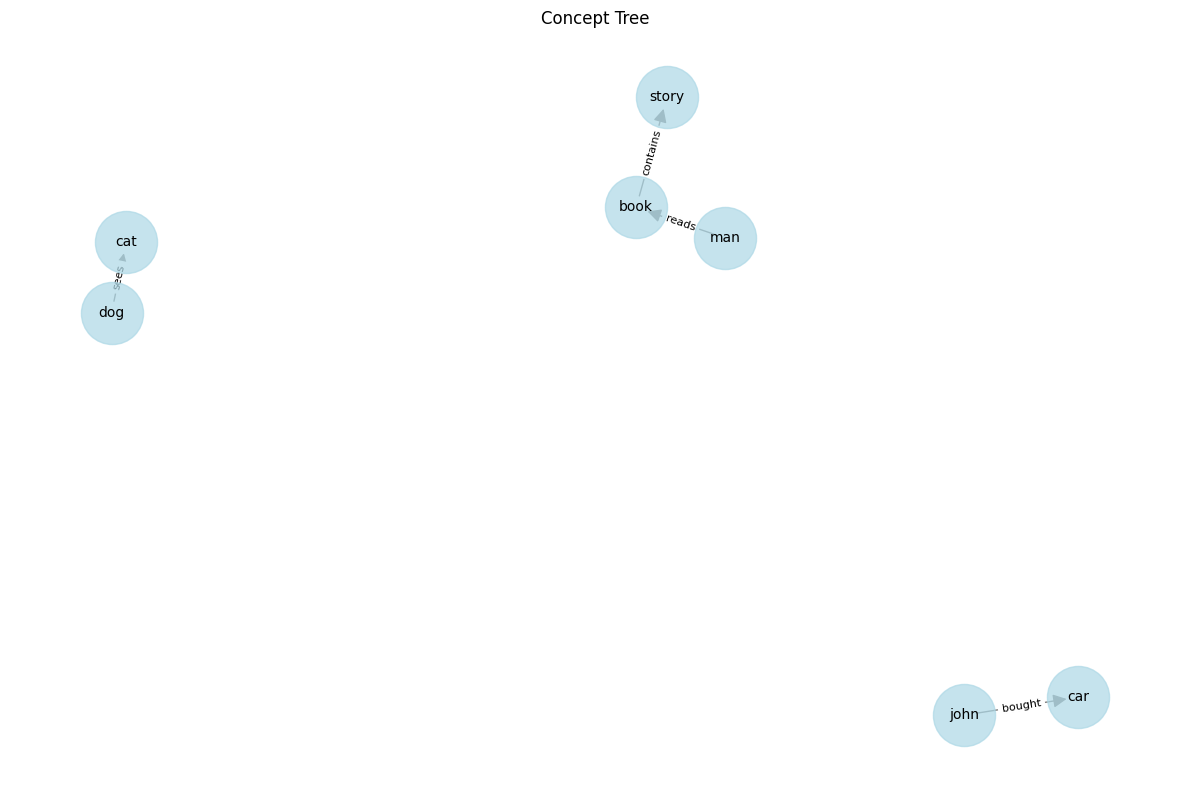

In [35]:
visualize_graph(graph1)

In [30]:
displacy.render(doc, style='dep')